![image.png](attachment:image.png)

# Tarefa II

Neste projeto, estamos construindo um credit scoring para cartão de crédito, em um desenho amostral com 15 safras, e utilizando 12 meses de performance.

Carregue a base de dados ```credit_scoring.ftr```.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn import metrics

import statsmodels.formula.api as smf
import statsmodels.api as sm

from scipy.stats import ks_2samp
from scipy.stats import t
from scipy.stats import ttest_ind


import warnings

In [ ]:
sns.set_style("whitegrid")

In [ ]:
df = pd.read_feather('credit_scoring.ftr')
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


## Amostragem

Separe os três últimos meses como safras de validação *out of time* (oot).

Variáveis:<br>
Considere que a variável ```data_ref``` não é uma variável explicativa, é somente uma variável indicadora da safra, e não deve ser utilizada na modelagem. A variávei ```index``` é um identificador do cliente, e também não deve ser utilizada como covariável (variável explicativa). As restantes podem ser utilizadas para prever a inadimplência, incluindo a renda.


In [ ]:
# Ordenando o dataframe pela data
df.sort_values('data_ref', inplace=True)

# Encontrando a data que marca o início dos últimos três meses
start_oot = df['data_ref'].unique()[-3]

# Criando o conjunto de validação out of time
df_oot = df[df['data_ref'] >= start_oot]

# Criando o conjunto de treinamento
df_train = df[df['data_ref'] < start_oot]

## Descritiva básica univariada

- Descreva a base quanto ao número de linhas, número de linhas para cada mês em ```data_ref```.
- Faça uma descritiva básica univariada de cada variável. Considere as naturezas diferentes: qualitativas e quantitativas.

In [ ]:
# Número de linhas
num_linhas = df.shape[0]
print(f'Número de linhas: {num_linhas}')

# Número de linhas para cada mês em 'data_ref'
num_linhas_data_ref = df['data_ref'].value_counts()
print('Número de linhas para cada mês em data_ref:')
print(num_linhas_data_ref)

Número de linhas: 750000
Número de linhas para cada mês em data_ref:
data_ref
2015-01-01    50000
2015-02-01    50000
2015-03-01    50000
2015-04-01    50000
2015-05-01    50000
2015-06-01    50000
2015-07-01    50000
2015-08-01    50000
2015-09-01    50000
2015-10-01    50000
2015-11-01    50000
2015-12-01    50000
2016-01-01    50000
2016-02-01    50000
2016-03-01    50000
Name: count, dtype: int64


In [ ]:
# Descritiva básica univariada de cada variável
for col in df.columns:
    print(f'\nDescritiva básica univariada para {col}:')
    if df[col].dtype == 'object':
        # Se a variável é qualitativa, mostra a frequência de cada categoria
        print(df[col].value_counts())
    else:
        # Se a variável é quantitativa, mostra medidas resumo como média, mediana, etc.
        print(df[col].describe())


Descritiva básica univariada para data_ref:
count                 750000
mean     2015-08-01 06:24:00
min      2015-01-01 00:00:00
25%      2015-04-01 00:00:00
50%      2015-08-01 00:00:00
75%      2015-12-01 00:00:00
max      2016-03-01 00:00:00
Name: data_ref, dtype: object

Descritiva básica univariada para index:
count    750000.000000
mean       8319.272793
std        4809.281774
min           0.000000
25%        4147.000000
50%        8324.000000
75%       12487.000000
max       16649.000000
Name: index, dtype: float64

Descritiva básica univariada para sexo:
sexo
F    504580
M    245420
Name: count, dtype: int64

Descritiva básica univariada para posse_de_veiculo:
posse_de_veiculo
N    457954
S    292046
Name: count, dtype: int64

Descritiva básica univariada para posse_de_imovel:
posse_de_imovel
S    503692
N    246308
Name: count, dtype: int64

Descritiva básica univariada para qtd_filhos:
count    750000.000000
mean          0.433251
std           0.739379
min           0.00

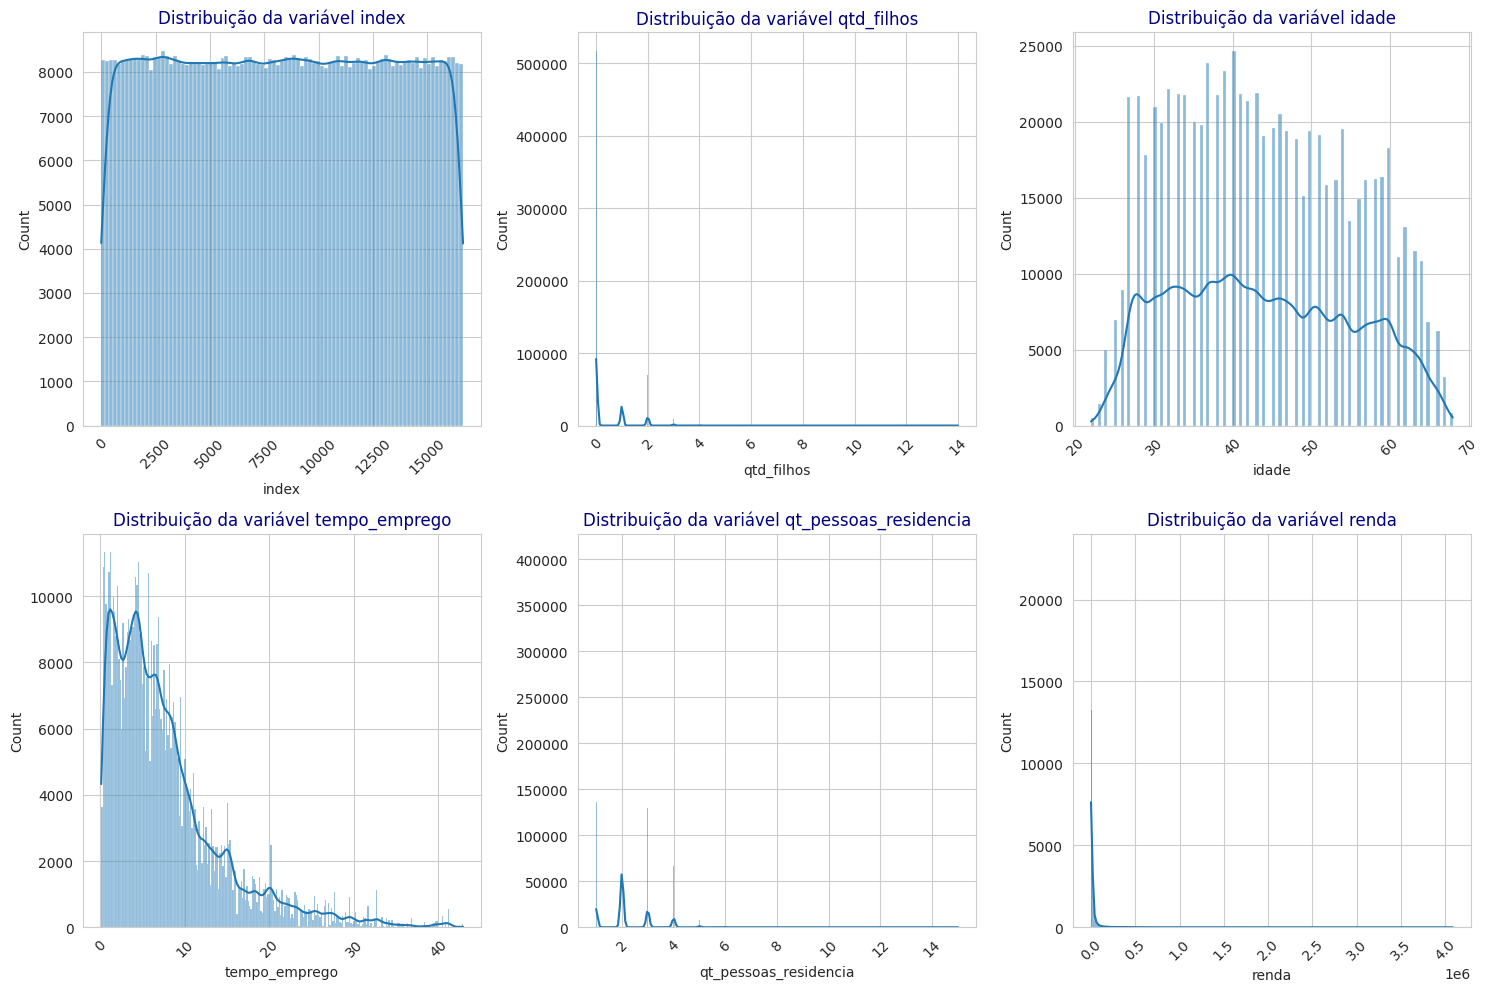

In [ ]:
# Gráficos para variáveis quantitativas
quant_vars = df.select_dtypes(include=[np.number]).columns
n_rows = int(np.ceil(len(quant_vars)/3))
fig, axs = plt.subplots(n_rows, 3, figsize=(15, 5*n_rows))
axs = axs.flatten()  # para facilitar a iteração
for i, col in enumerate(quant_vars):
    sns.histplot(data=df, x=col, kde=True, ax=axs[i])
    axs[i].set_title(f'Distribuição da variável {col}', color='navy')
    plt.setp(axs[i].xaxis.get_majorticklabels(), rotation=45)
plt.tight_layout()
plt.show()

## Descritiva bivariada

Faça uma análise descritiva bivariada de cada variável

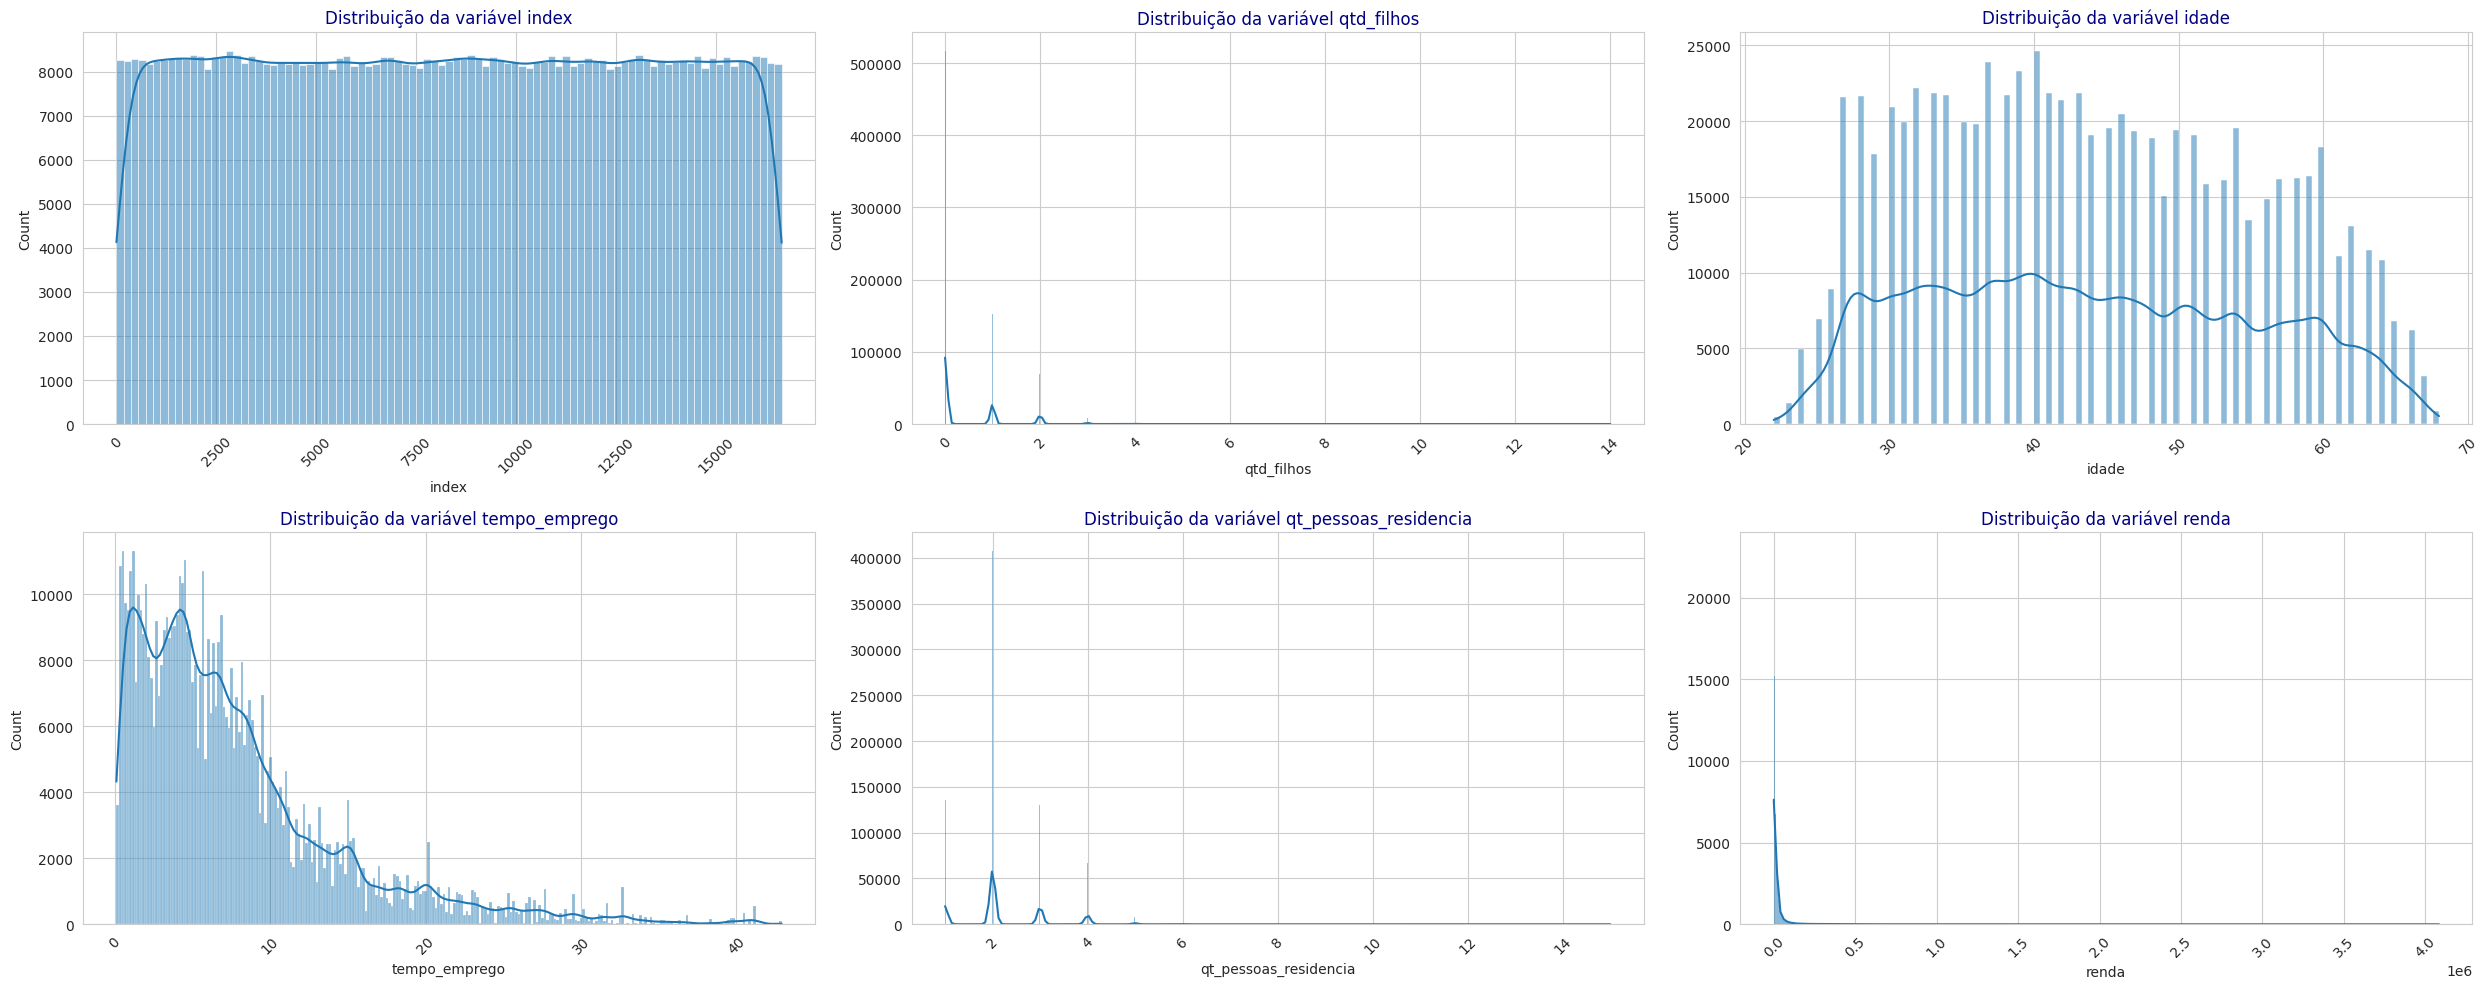

In [ ]:
# Gráficos para variáveis quantitativas
quant_vars = df.select_dtypes(include=[np.number]).columns
n_rows = int(np.ceil(len(quant_vars)/3))
fig, axs = plt.subplots(n_rows, 3, figsize=(25, 5*n_rows))
axs = axs.flatten()  # para facilitar a iteração
for i, col in enumerate(quant_vars):
    sns.histplot(data=df, x=col, kde=True, ax=axs[i])
    axs[i].set_title(f'Distribuição da variável {col}', color='navy')
    plt.setp(axs[i].xaxis.get_majorticklabels(), rotation=45)
plt.show()

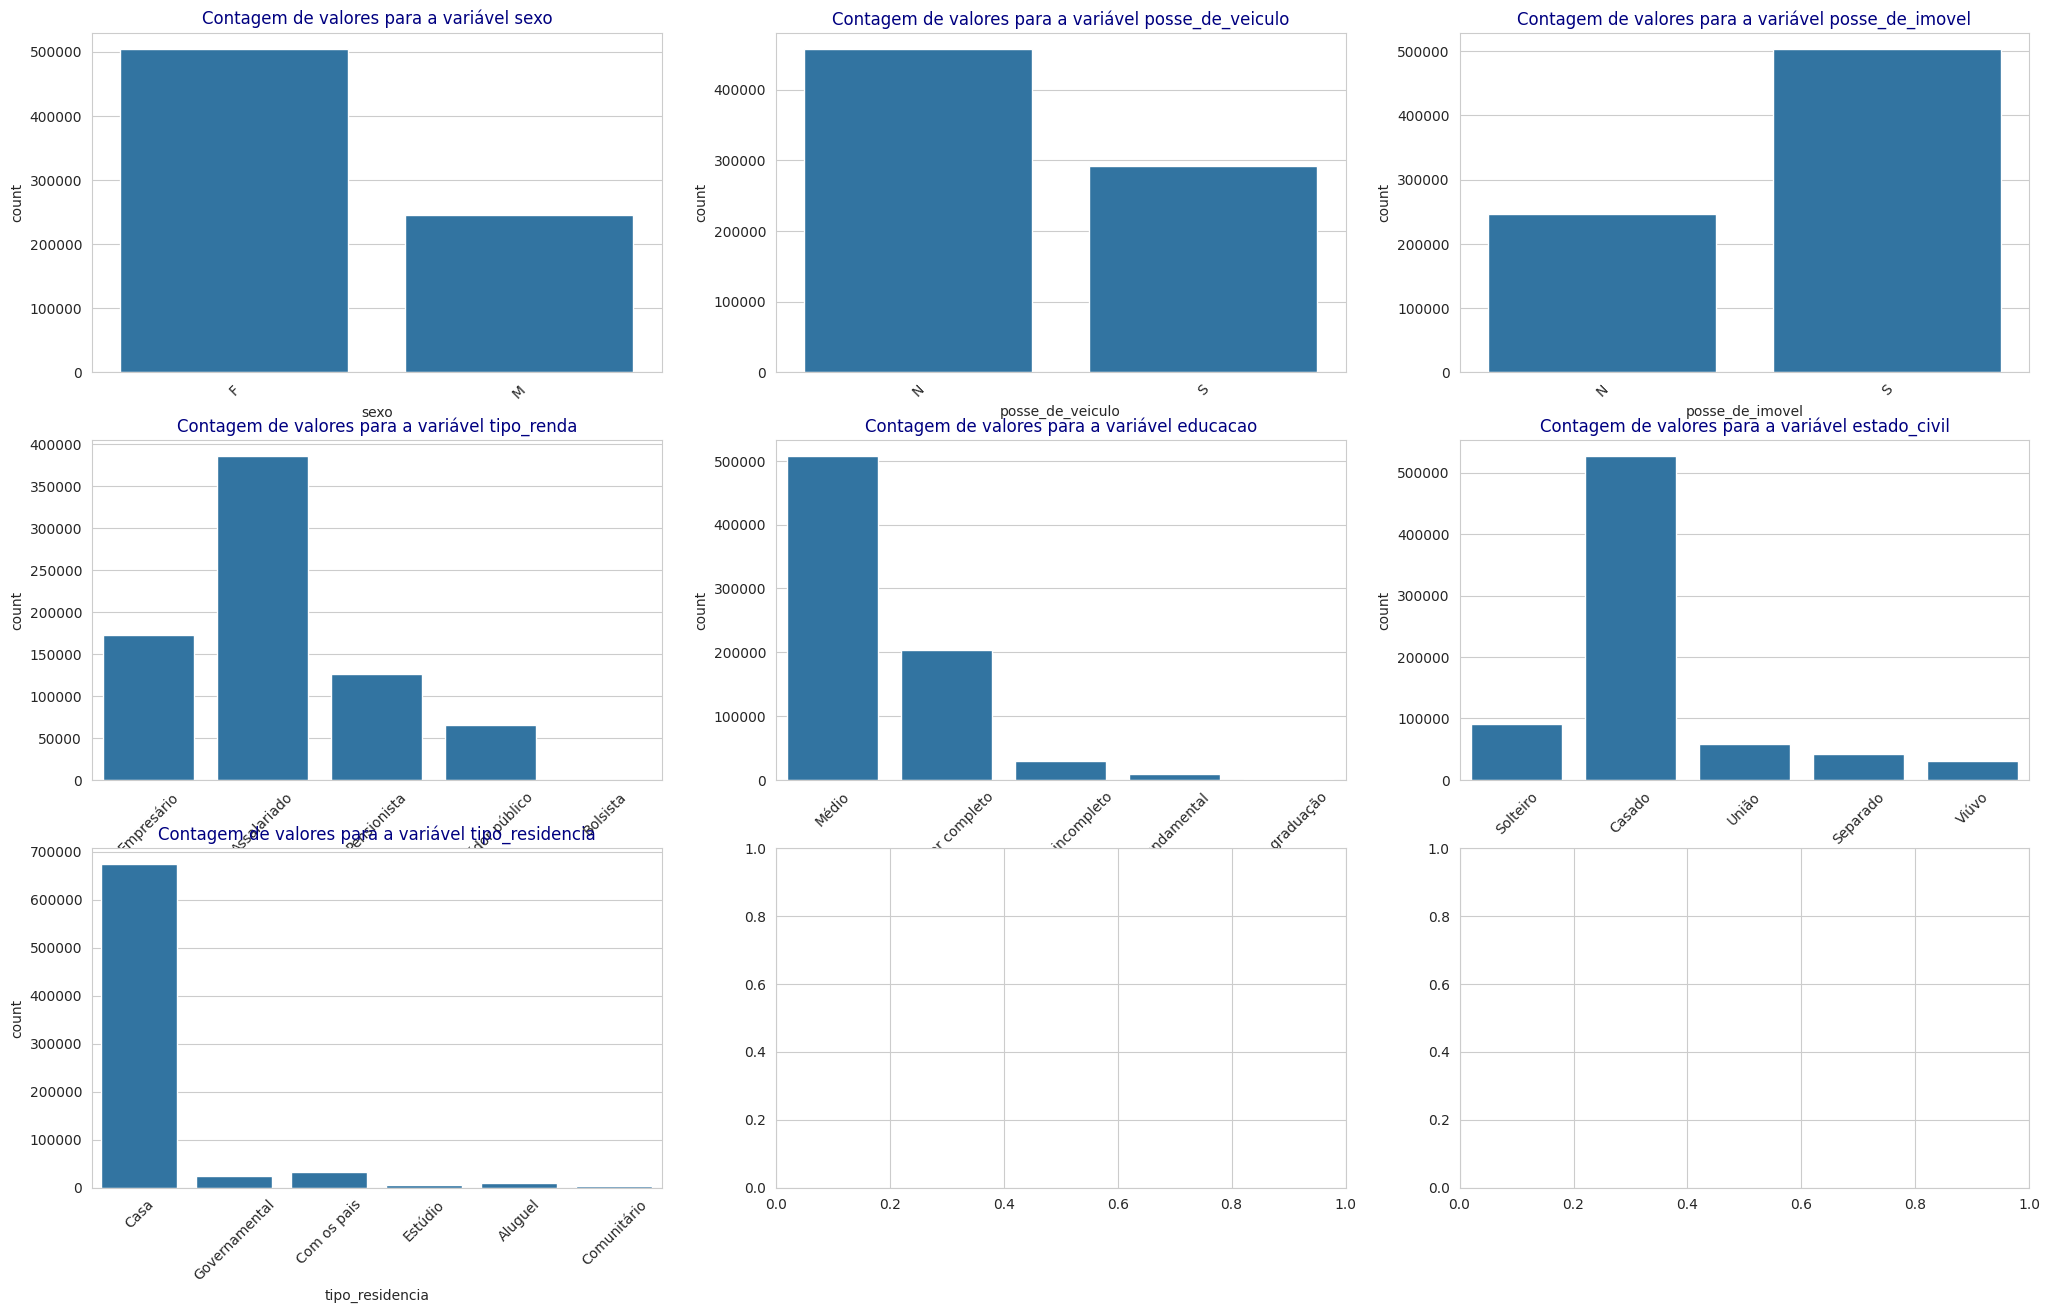

In [ ]:
# Gráficos para variáveis qualitativas
qual_vars = df.select_dtypes(include=['object']).columns
n_rows = int(np.ceil(len(qual_vars)/3))
fig, axs = plt.subplots(n_rows, 3, figsize=(25, 5*n_rows))
axs = axs.flatten()  # para facilitar a iteração
for i, col in enumerate(qual_vars):
    sns.countplot(data=df, x=col, ax=axs[i])
    axs[i].set_title(f'Contagem de valores para a variável {col}', color='navy')  # altere 'navy' para a cor desejada
    plt.setp(axs[i].xaxis.get_majorticklabels(), rotation=45)
plt.show()

## Desenvolvimento do modelo

Desenvolva um modelo de *credit scoring* através de uma regressão logística.

- Trate valores missings e outliers
- Trate 'zeros estruturais'
- Faça agrupamentos de categorias conforme vimos em aula
- Proponha uma equação preditiva para 'mau'
- Caso hajam categorias não significantes, justifique

In [ ]:
# Preenchendo os valores missing com a mediana (para variáveis numéricas) ou a moda (para variáveis categóricas)
for col in df.columns:
    if df[col].dtype == 'object':
        df[col].fillna(df[col].mode()[0], inplace=True)
    else:
        df[col].fillna(df[col].median(), inplace=True)

In [ ]:
print(df.isnull().sum())

data_ref                 0
index                    0
sexo                     0
posse_de_veiculo         0
posse_de_imovel          0
qtd_filhos               0
tipo_renda               0
educacao                 0
estado_civil             0
tipo_residencia          0
idade                    0
tempo_emprego            0
qt_pessoas_residencia    0
renda                    0
mau                      0
dtype: int64


In [ ]:
# Substitua os outliers pelo valor do percentil 95 (para valores altos) ou percentil 5 (para valores baixos)
for col in df.select_dtypes(include=[np.number]).columns:
    P95 = df[col].quantile(0.95)
    P5 = df[col].quantile(0.05)
    df[col] = np.where(df[col] > P95, P95, df[col])
    df[col] = np.where(df[col] < P5, P5, df[col])

# Substituindo os 'zeros estruturais' pela mediana
for col in df.select_dtypes(include=[np.number]).columns:
    median = df.loc[df[col] != 0, col].median()
    df[col] = np.where(df[col] == 0, median, df[col])

# Substituindo a variável de data/hora por várias variáveis numéricas
for col in df.select_dtypes(include=['datetime64']).columns:
    df[col+'_ano'] = df[col].dt.year
    df[col+'_mes'] = df[col].dt.month
    df[col+'_dia'] = df[col].dt.day
    df[col+'_dia_da_semana'] = df[col].dt.weekday
    df = df.drop(col, axis=1)

# Agrupando as categorias com frequências muito baixas em uma única categoria 'Outros'
for col in df.select_dtypes(include=['object']).columns:
    freq = df[col].value_counts(normalize=True)
    small_categories = freq[freq < 0.01].index
    df[col] = np.where(df[col].isin(small_categories), 'Outros', df[col])

# Codificação das variáveis categóricas
df = pd.get_dummies(df, drop_first=True)
# Separação das variáveis independentes e dependente
X = df.drop('mau', axis=1)
y = df['mau']
# Divisão dos dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Padronização das variáveis independentes
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
# Ajuste do modelo de regressão logística
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [ ]:
# Avaliação do modelo
y_pred = model.predict(X_test)
print(confusion_matrix(y_test, y_pred))

[[138364      0]
 [ 11636      0]]


In [ ]:
# Avaliação do modelo
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.92      1.00      0.96    138364
        True       0.00      0.00      0.00     11636

    accuracy                           0.92    150000
   macro avg       0.46      0.50      0.48    150000
weighted avg       0.85      0.92      0.89    150000



## Avaliação do modelo

Avalie o poder discriminante do modelo pelo menos avaliando acurácia, KS e Gini.

Avalie estas métricas nas bases de desenvolvimento e *out of time*.

In [ ]:
# Calculando a acurácia
accuracy = accuracy_score(y_test, y_pred)
print(f'Acurácia: {accuracy}')

# Calculando o KS
ks_statistic, ks_pvalue = ks_2samp(y_pred[y_test == 0], y_pred[y_test == 1])
print(f'KS: {ks_statistic}')

# Calculando o Gini
roc_auc = roc_auc_score(y_test, y_pred)
gini = 2*roc_auc - 1
print(f'Gini: {gini}')

Acurácia: 0.9224266666666666
KS: 0.0
Gini: 0.0


Os resultados mostram que o modelo tem uma acurácia de 92,24%, o que significa que ele classifica corretamente 92,24% dos casos. Porém, o valor de KS e Gini são 0, o que nos diz que o modelo não consegue distinguir as classes diferentes.


